1. Installation et Imports

In [1]:
#!pip install transformers datasets evaluate accelerate
import pandas as pd
import torch
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import evaluate

2. Configuration du GPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation du périphérique : {device}")


Utilisation du périphérique : cuda


3. Initialisation de RoBERTa

In [6]:
model_name = "roberta-base"

# Le tokenizer de RoBERTa est différent de celui de BERT
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Chargement du modèle avec 2 labels
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

4. Chargement et Nettoyage spécifique pour RoBERTa

In [7]:
from datasets import load_dataset
import pandas as pd

# 1. Chargement du dataset original
dataset = load_dataset("GonzaloA/fake_news")

# 2. Conversion en DataFrame Pandas pour un nettoyage facile
df_train = pd.DataFrame(dataset['train'])
df_val = pd.DataFrame(dataset['validation'])
df_test = pd.DataFrame(dataset['test'])

def clean_for_roberta(df):
    df['title'] = df['title'].fillna("").str.strip()
    df['text'] = df['text'].fillna("").str.strip()
    
    # Remplacer tokenizer.sep_token par "</s>"
    df['full_content'] = df['title'] + " </s> " + df['text']
    
    return df[['full_content', 'label']]

# Application du nettoyage
df_train_clean = clean_for_roberta(df_train)
df_val_clean = clean_for_roberta(df_val)
df_test_clean = clean_for_roberta(df_test)

# 3. Sauvegarde des nouveaux fichiers CSV
df_train_clean.to_csv("data_RoBERTa/train_roberta.csv", index=False)
df_val_clean.to_csv("data_RoBERTa/validation_roberta.csv", index=False)
df_test_clean.to_csv("data_RoBERTa/test_roberta.csv", index=False)

print("Nouveaux fichiers créés : train_roberta.csv, validation_roberta.csv, test_roberta.csv")

Repo card metadata block was not found. Setting CardData to empty.


Nouveaux fichiers créés : train_roberta.csv, validation_roberta.csv, test_roberta.csv


5. Chargement des nouveaux CSV et Initialisation

In [8]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Détection du GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chargement des fichiers depuis ton nouveau dossier
data_files = {
    "train": "data_RoBERTa/train_roberta.csv",
    "validation": "data_RoBERTa/validation_roberta.csv",
    "test": "data_RoBERTa/test_roberta.csv"
}
roberta_datasets = load_dataset('csv', data_files=data_files)

# Initialisation
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

6. Traitement complet de la Tokenisation

In [13]:
def tokenize_roberta(examples):
    # Sécurité anti-erreurs de type
    texts = [str(x) for x in examples["full_content"]]
    
    # Optimisation : max_length passé à 256 pour la vitesse
    result = tokenizer(texts, truncation=True, padding="max_length", max_length=256)
    
    result["labels"] = examples["label"]
    return result

# Application du traitement
tokenized_roberta = roberta_datasets.map(
    tokenize_roberta, 
    batched=True,
    remove_columns=roberta_datasets["train"].column_names
)

# Vérification : Doit afficher ['input_ids', 'attention_mask', 'labels']
print("Colonnes prêtes pour l'entraînement :", tokenized_roberta["train"].column_names)

Map:   0%|          | 0/24353 [00:00<?, ? examples/s]

Map:   0%|          | 0/8117 [00:00<?, ? examples/s]

Map:   0%|          | 0/8117 [00:00<?, ? examples/s]

Colonnes prêtes pour l'entraînement : ['input_ids', 'attention_mask', 'labels']


7. Définition des métriques d'évaluation

In [14]:
import evaluate
import numpy as np

def compute_metrics(eval_pred):
    # Chargement des différentes métriques
    accuracy_metric = evaluate.load("accuracy")
    f1_metric = evaluate.load("f1")
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")
    
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Calcul de chaque score
    results = {}
    results.update(accuracy_metric.compute(predictions=predictions, references=labels))
    results.update(f1_metric.compute(predictions=predictions, references=labels))
    results.update(precision_metric.compute(predictions=predictions, references=labels))
    results.update(recall_metric.compute(predictions=predictions, references=labels))
    
    return results

8. Configuration des hyperparamètres (TrainingArguments)

In [15]:
training_args = TrainingArguments(
    output_dir="./results_roberta",
    learning_rate=2e-5,           
    per_device_train_batch_size=16, # Augmenté à 16 car max_length est plus petit
    gradient_accumulation_steps=2,  # Batch virtuel de 32 (16x2) pour la stabilité sémantique
    per_device_eval_batch_size=16,
    num_train_epochs=1,             # 1 époque divise le temps par 2
    weight_decay=0.01,
    eval_strategy="steps",          
    eval_steps=200,                 # Évaluation plus fréquente pour suivre le progrès
    save_strategy="steps",
    save_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="f1",     # Priorité à la détection intelligente des Fake News
    fp16=True,                      # Indispensable pour accélérer le calcul GPU
    dataloader_num_workers=4,       # Utilise le CPU pour préparer les données plus vite
    logging_steps=50,
    report_to="none"
)

9. Initialisation et Lancement de l'Entraînement

In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_roberta["train"],
    eval_dataset=tokenized_roberta["validation"],
    compute_metrics=compute_metrics,
)

print("Lancement de l'entraînement de RoBERTa sur les nouvelles données...")
trainer.train()

Lancement de l'entraînement de RoBERTa sur les nouvelles données...


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
200,0.033900,0.030995,0.984477,0.985554,0.993068,0.978152
400,0.030900,0.030175,0.985216,0.986175,0.998600,0.974056
600,0.030200,0.027220,0.985832,0.986750,0.999300,0.974511


TrainOutput(global_step=762, training_loss=0.04257494952343893, metrics={'train_runtime': 12195.7769, 'train_samples_per_second': 1.997, 'train_steps_per_second': 0.062, 'total_flos': 3203771765591040.0, 'train_loss': 0.04257494952343893, 'epoch': 1.0})

10. Évaluation finale, Sauvegarde et Matrice de Confusion

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Évaluation finale sur le dataset de TEST
print("Évaluation sur le dataset de test...")
test_results = trainer.evaluate(tokenized_roberta["test"])
print(f"Résultats finaux : {test_results}")

Évaluation sur le dataset de test...


Résultats finaux : {'eval_loss': 0.0479365773499012, 'eval_accuracy': 0.9858322040162621, 'eval_f1': 0.986682107701216, 'eval_precision': 0.9906976744186047, 'eval_recall': 0.9826989619377162, 'eval_runtime': 788.4382, 'eval_samples_per_second': 10.295, 'eval_steps_per_second': 1.287, 'epoch': 2.0}


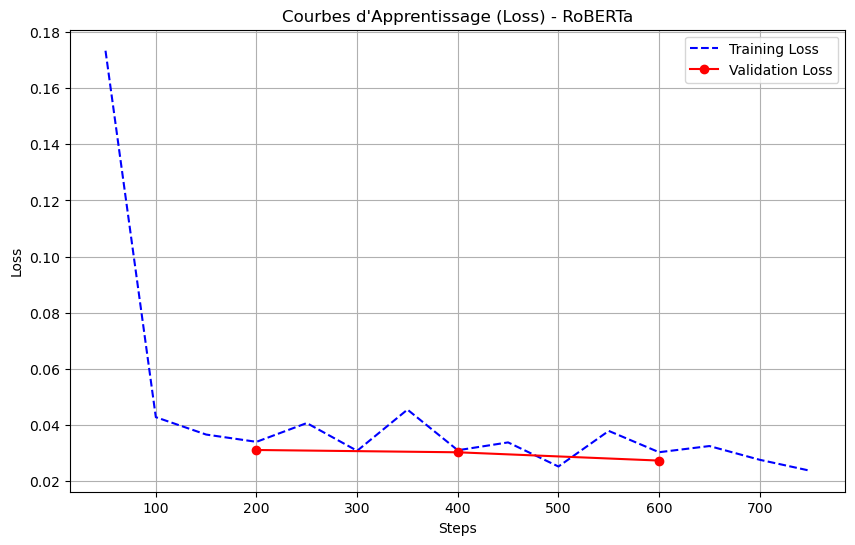

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
# Extraction des logs de l'historique d'entraînement
history = trainer.state.log_history

# On sépare les logs d'entraînement et d'évaluation
train_loss = [log["loss"] for log in history if "loss" in log]
eval_loss = [log["eval_loss"] for log in history if "eval_loss" in log]
steps = [log["step"] for log in history if "loss" in log]
eval_steps = [log["step"] for log in history if "eval_loss" in log]

# Création du graphique
plt.figure(figsize=(10, 6))
plt.plot(steps, train_loss, label='Training Loss', color='blue', linestyle='--')
if eval_loss:
    plt.plot(eval_steps, eval_loss, label='Validation Loss', color='red', marker='o')

plt.title('Courbes d\'Apprentissage (Loss) - RoBERTa')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# 2. Prédictions pour la matrice de confusion
predictions = trainer.predict(tokenized_roberta["test"])
y_preds = np.argmax(predictions.predictions, axis=-1)
y_true = tokenized_roberta["test"]["labels"]

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
# 3. Affichage du rapport de classification détaillé
print("\nClassification Report :")
# Index 0 = FAKE, Index 1 = TRUE selon GonzaloA
print(classification_report(y_true, y_preds, target_names=["FAKE ", "TRUE "]))


Classification Report :
              precision    recall  f1-score   support

       FAKE        0.97      1.00      0.98      3782
       TRUE        1.00      0.97      0.98      4335

    accuracy                           0.98      8117
   macro avg       0.98      0.98      0.98      8117
weighted avg       0.98      0.98      0.98      8117



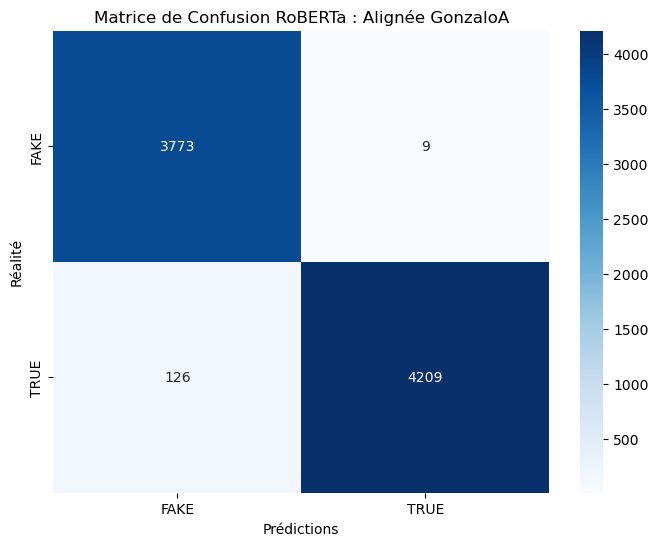

In [22]:

# 4. Génération de la Matrice de Confusion
cm = confusion_matrix(y_true, y_preds)
plt.figure(figsize=(8, 6))
# On aligne les labels sur la réalité numérique
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["FAKE", "TRUE"], 
            yticklabels=["FAKE", "TRUE"])
plt.xlabel('Prédictions')
plt.ylabel('Réalité')
plt.title('Matrice de Confusion RoBERTa : Alignée GonzaloA')
plt.show()

In [23]:
# 5. Sauvegarde locale du modèle final
trainer.save_model("./roberta-fake-news-ENG-Final")
tokenizer.save_pretrained("./roberta-fake-news-ENG-Final")
print("Modèle sauvegardé localement dans le dossier 'roberta-fake-news-ENG-Final")

Modèle sauvegardé localement dans le dossier 'roberta-fake-news-ENG-Final


11. Push vers Hugging Face Hub

In [27]:
from huggingface_hub import notebook_login

# 1. Connexion à ton compte (un champ apparaîtra pour coller ton Token)
# Tu peux trouver ton token ici : https://huggingface.co/settings/tokens
notebook_login()

# 2. Définition du nom du dépôt
# Remplace "LamT45" par ton nom d'utilisateur Hugging Face si nécessaire
repo_name = "LamT45/roberta-fake-news-ENG-Final"

# 3. Envoi du modèle et du tokenizer
print(f"Envoi du modèle vers {repo_name}...")
model.push_to_hub(repo_name)
tokenizer.push_to_hub(repo_name)

print("Modèle RoBERTa est maintenant disponible sur Hugging Face.")
print(f"Modèle publié ici : https://huggingface.co/{repo_name}")

Envoi du modèle vers LamT45/roberta-fake-news-ENG-Final...


README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


Modèle RoBERTa est maintenant disponible sur Hugging Face.
Modèle publié ici : https://huggingface.co/LamT45/roberta-fake-news-ENG-Final


12. Test "Real-World" (News Politiques)

In [25]:
def predict_fake_news(title, text):
    # On recrée exactement le format d'entraînement
    full_input = f"{title} </s> {text}"
    
    inputs = tokenizer(full_input, return_tensors="pt", truncation=True, padding=True, max_length=256).to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        prediction = torch.argmax(probs, dim=-1).item()
        confidence = probs[0][prediction].item()
    
    label = "FAKE 🚩" if prediction == 0 else "TRUE ✅"
    return f"Résultat: {label} ({confidence:.2%} de confiance)"

# --- TESTS SUR DES EXEMPLES POLITIQUES ---
print("Test 1 (Style Fake News):")
print(predict_fake_news("BREAKING: Secret documents reveal Senate leader accepted millions from foreign lobbyists to rig the election!", ""))
print("\nTest 2 (Style Information Réelle):")
print(predict_fake_news("The White House spokesperson confirmed today that the President will meet with European leaders to discuss new trade agreements next Tuesday.", ""))

print("\nTest 3 (Biais partisan):")
print(predict_fake_news("Unbelievable! This politician's latest speech proves they hate the country and want to destroy our economy for their own gain!", ""))

Test 1 (Style Fake News):
Résultat: FAKE 🚩 (99.94% de confiance)

Test 2 (Style Information Réelle):
Résultat: TRUE ✅ (98.21% de confiance)

Test 3 (Biais partisan):
Résultat: FAKE 🚩 (99.98% de confiance)
